In [4]:
# module imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random
# model imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
# processing imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from keras.utils import to_categorical
from keras.layers import Dense, LSTM, MaxPool1D, Flatten, Dropout # importing dense layer
from keras.models import Sequential #importing Sequential layer
from keras.layers import Input
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D

In [9]:
# fetch the training file
#file_path_20_percent = '../input/nslkdd/KDDTrain+_20Percent.txt'
file_path_full_training_set = 'KDDTrain+.txt'
file_path_test = 'KDDTest+.txt'
#df = pd.read_csv(file_path_20_percent)
df = pd.read_csv(file_path_full_training_set)
test_df = pd.read_csv(file_path_test)
# add the column labels
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])
df.columns = columns
test_df.columns = columns
# map normal to 0, all attacks to 1
is_attack = df.attack.map(lambda a: 0 if a == 'normal' else 1)
test_attack = test_df.attack.map(lambda a: 0 if a == 'normal' else 1)
#data_with_attack = df.join(is_attack, rsuffix='_flag')
df['attack_flag'] = is_attack
test_df['attack_flag'] = test_attack
# lists to hold our attack classifications
dos_attacks = ['apache2','back','land','neptune','mailbomb','pod','processtable','smurf']
probe_attacks = ['ipsweep','mscan','nmap','portsweep','saint','satan']
privilege_attacks = ['buffer_overflow','loadmdoule','perl','ps','rootkit','sqlattack','xte']
access_attacks = ['ftp_write','guess_passwd','http_tunnel','imap','multihop','named','phf']
# we will use these for plotting below
attack_labels = ['Normal','DoS','Probe','Privilege','Access']
# helper function to pass to data frame mapping
def map_attack(attack):
    if attack in dos_attacks:
    # dos_attacks map to 1
        attack_type = 1
    elif attack in probe_attacks:
    # probe_attacks mapt to 2
        attack_type = 2
    elif attack in privilege_attacks:
    # privilege escalation attacks map to 3
        attack_type = 3
    elif attack in access_attacks:
    # remote access attacks map to 4
        attack_type = 4
    else:
    # normal maps to 0
        attack_type = 0
    return attack_type
# map the data and join to the data set
attack_map = df.attack.apply(map_attack)
df['attack_map'] = attack_map
test_attack_map = test_df.attack.apply(map_attack)
test_df['attack_map'] = test_attack_map
le=LabelEncoder()
clm=['protocol_type', 'service', 'flag', 'attack']
for x in clm:
    df[x]=le.fit_transform(df[x])
    test_df[x]=le.fit_transform(test_df[x])
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag,attack_map
0,0,2,44,9,146,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.00,0.00,11,15,0,0
1,0,1,49,5,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,9,19,1,1
2,0,1,24,9,232,8153,0,0,0,0,...,0.03,0.04,0.03,0.01,0.00,0.01,11,21,0,0
3,0,1,24,9,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,11,21,0,0
4,0,1,49,1,0,0,0,0,0,0,...,0.00,0.00,0.00,0.00,1.00,1.00,9,21,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125967,0,1,49,5,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,9,20,1,1
125968,8,2,49,9,105,145,0,0,0,0,...,0.01,0.00,0.00,0.00,0.00,0.00,11,21,0,0
125969,0,1,54,9,2231,384,0,0,0,0,...,0.00,0.00,0.72,0.00,0.01,0.00,11,18,0,0
125970,0,1,30,5,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,9,20,1,1


In [ ]:
x_train=df.drop('attack_flag',axis=1)
x_train=x_train.drop('attack',axis=1)
x_train=x_train.drop('attack_map',axis=1)
x_train=x_train.drop('level',axis=1)
y_train=df[['attack_flag']]
X_train, X_test, Y_train, Y_test = train_test_split(x_train,y_train, test_size=0.20)

X_train = np.array(X_train)
X_test = np.array(X_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#lstm-input
# X_train = np.reshape(X_train, ( X_train.shape[0], 1 , X_train.shape[1] ))
Y_train = np.array(Y_train)
# X_test = np.array(x_test)
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Y_test = np.array(y_test)
model = Sequential() # initializing model
#lstm
# model.add(LSTM(64,return_sequences=True,input_shape = (1, X_train.shape[2])))
# model.add(Dropout(0.2))
# model.add(LSTM(64,return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(64,return_sequences=True))
# model.add(Flatten())
# model.add(Dense(units=1))
#cnn
# model.add(Conv1D(32, 9, padding="same",input_shape = (X_train.shape[1], 1), activation='
# model.add(MaxPool1D(pool_size=(2)))
# model.add(Dropout(0.2))
# model.add(Conv1D(32, 3, padding="same", activation='relu'))
# model.add(MaxPool1D(pool_size=(4)))
# model.add(Dropout(0.2))
# model.add(Dense(units=1))
# cnn-lstm
model.add(Conv1D(32, 9, padding="same",input_shape = (X_train.shape[1], 1), activation='relu'))
model.add(MaxPool1D(pool_size=(2)))
model.add(LSTM(units=16,return_sequences=False,dropout=0.2))
model.add(Dense(units=1))
# model.add(LSTM(64,return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(64,return_sequences=True))
# model.add(Flatten())
# model.add(LSTM(units=512,return_sequences=False,dropout=0.2))
# model.add(Activation('sigmoid'))
# output layer with softmax activation
# model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model.fit(X_train, Y_train, epochs=10, batch_size=250,validation_split=0.1)

c:\Users\Taha\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8301 - loss: 0.4799 - val_accuracy: 0.8860 - val_loss: 0.2197
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9038 - loss: 0.2563 - val_accuracy: 0.9324 - val_loss: 0.1766
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9298 - loss: 0.1971 - val_accuracy: 0.9489 - val_loss: 0.1564
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9426 - loss: 0.1696 - val_accuracy: 0.9563 - val_loss: 0.1376
Epoch 5/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9470 - loss: 0.1512 - val_accuracy: 0.9466 - val_loss: 0.1261
Epoch 6/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9479 - loss: 0.1480 - val_accuracy: 0.9634 - val_loss: 0.1121
Epoch 7/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9539 - loss: 0.1277 - val_accuracy: 0.9665 - val_loss: 0.0982
Epoch 8/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9554 - loss: 0.1240 - val_acc

788/788 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9763 - loss: 0.0790


Text(0, 0.5, 'Loss')

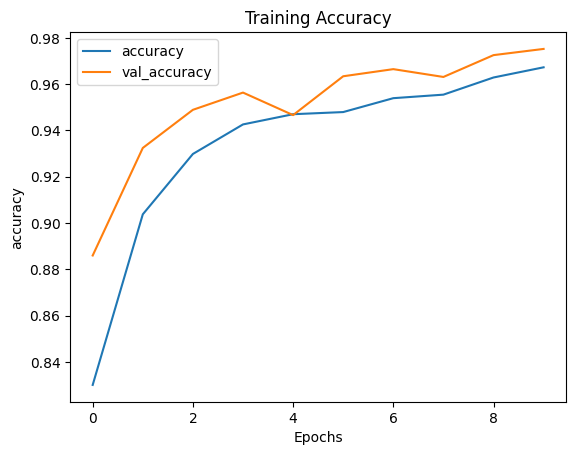

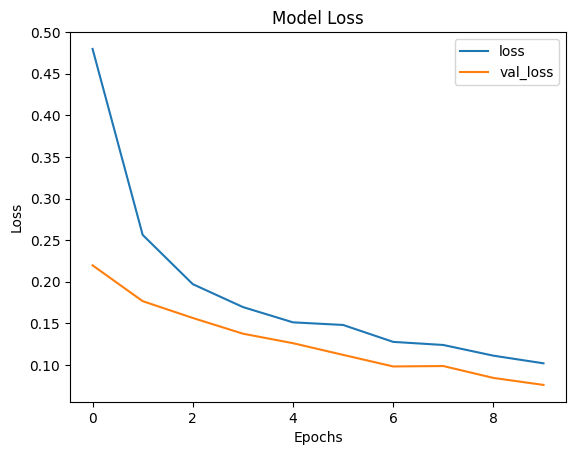

In [14]:

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
Y_test = np.array(Y_test)
test_results = model.evaluate(X_test, Y_test, verbose=1)
pd.DataFrame(history.history)
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')


In [15]:

from sklearn.metrics import classification_report
Y_predict = model.predict(X_test)
Y_pred = Y_predict.argmax(axis=-1)
Y_test = Y_test.argmax(axis = -1 )
report = classification_report(Y_test, Y_pred)
print(report)

788/788 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25195

    accuracy                           1.00     25195
   macro avg       1.00      1.00      1.00     25195
weighted avg       1.00      1.00      1.00     25195



c:\Users\Taha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


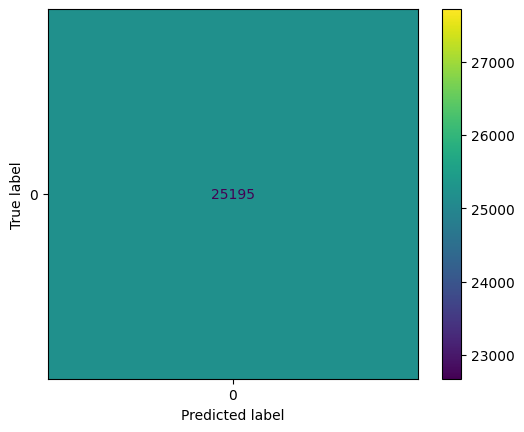

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# compute the confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
# create a ConfusionMatrixDisplay object
cm_display = ConfusionMatrixDisplay(cm)
# plot the confusion matrix
cm_display.plot()
plt.show()